In [7]:
# 04_train_prototype.ipynb
# Training + evaluation prototype with train/val split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score, multilabel_confusion_matrix
import numpy as np
import sys
import os

# Add the notebook directory to path to import from previous cells
sys.path.append('.')

# Import our custom classes from the previous notebook
# We'll recreate them here for this training script

# ---- Dataset class (from 03_dataset_prototype.ipynb) ----
import pandas as pd
import json
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision import transforms
from typing import Tuple, Dict, List

class ChestXrayDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for Chest X-ray images with multi-hot encoded labels."""
    
    def __init__(self, metadata_path: str, images_dir: str, class_to_idx_path: str = None):
        self.metadata_path = metadata_path
        self.images_dir = images_dir
        self.class_to_idx_path = class_to_idx_path or "../data/class_to_idx.json"
        
        # Load metadata
        self.metadata = pd.read_csv(metadata_path)
        
        # Build class_to_idx mapping if not exists
        if os.path.exists(self.class_to_idx_path):
            with open(self.class_to_idx_path, 'r') as f:
                self.class_to_idx = json.load(f)
        else:
            self.class_to_idx = self._build_class_mapping()
            self._save_class_mapping()
        
        # Build view mapping
        self.view_to_idx = self._build_view_mapping()
        
        # Image preprocessing transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])
        
        # Filter out samples where image doesn't exist
        self.valid_indices = self._filter_valid_samples()
        
    def _build_class_mapping(self) -> Dict[str, int]:
        """Build class_to_idx mapping from finding column."""
        all_classes = set()
        
        for finding in self.metadata['finding'].dropna():
            # Split on '/' for multiple diseases
            classes = [cls.strip() for cls in finding.split('/')]
            all_classes.update(classes)
        
        # Sort for consistent ordering
        sorted_classes = sorted(list(all_classes))
        return {cls: idx for idx, cls in enumerate(sorted_classes)}
    
    def _build_view_mapping(self) -> Dict[str, int]:
        """Build view_to_idx mapping from view column."""
        unique_views = sorted(self.metadata['view'].dropna().unique())
        return {view: idx for idx, view in enumerate(unique_views)}
    
    def _save_class_mapping(self):
        """Save class_to_idx mapping to JSON file."""
        os.makedirs(os.path.dirname(self.class_to_idx_path), exist_ok=True)
        with open(self.class_to_idx_path, 'w') as f:
            json.dump(self.class_to_idx, f, indent=2)
    
    def _filter_valid_samples(self) -> List[int]:
        """Filter out samples where image file doesn't exist."""
        valid_indices = []
        for idx, row in self.metadata.iterrows():
            image_path = os.path.join(self.images_dir, row['filename'])
            if os.path.exists(image_path):
                valid_indices.append(idx)
        return valid_indices
    
    def _encode_finding(self, finding: str) -> torch.Tensor:
        """Convert finding string to multi-hot encoded vector."""
        if pd.isna(finding):
            return torch.zeros(len(self.class_to_idx), dtype=torch.float32)
        
        # Split on '/' for multiple diseases
        classes = [cls.strip() for cls in finding.split('/')]
        
        # Create multi-hot vector
        label_vector = torch.zeros(len(self.class_to_idx), dtype=torch.float32)
        for cls in classes:
            if cls in self.class_to_idx:
                label_vector[self.class_to_idx[cls]] = 1.0
        
        return label_vector
    
    def _encode_view(self, view: str) -> torch.Tensor:
        """Convert view string to one-hot encoded vector."""
        if pd.isna(view):
            return torch.zeros(len(self.view_to_idx), dtype=torch.float32)
        
        view_vector = torch.zeros(len(self.view_to_idx), dtype=torch.float32)
        if view in self.view_to_idx:
            view_vector[self.view_to_idx[view]] = 1.0
        
        return view_vector
    
    def __len__(self) -> int:
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Get a sample from the dataset. This version handles missing/corrupt images gracefully by
        falling back to a black placeholder image and logging a warning instead of raising an error.
        """
        # Get the actual index in metadata
        actual_idx = self.valid_indices[idx]
        row = self.metadata.iloc[actual_idx]
        
        # Load and preprocess image
        image_path = os.path.join(self.images_dir, row['filename'])
        placeholder = Image.new('RGB', (224, 224), (0, 0, 0))

        try:
            if not os.path.exists(image_path):
                # If missing, use placeholder and warn
                print(f"⚠️ Missing image, using placeholder: {image_path}")
                image = placeholder
            else:
                # Try to open the image; handle corrupted files
                try:
                    image = Image.open(image_path).convert('RGB')
                except Exception as e:
                    print(f"⚠️ Failed to open image {image_path}: {e}. Using placeholder.")
                    image = placeholder
        except Exception as e:
            # Any unexpected error, fall back to placeholder
            print(f"⚠️ Error accessing image {image_path}: {e}. Using placeholder.")
            image = placeholder

        # Apply transforms
        try:
            image_tensor = self.transform(image)
        except Exception as e:
            # If transform fails for any reason, fall back to zeros tensor of expected shape
            print(f"⚠️ Transform failed for {image_path}: {e}. Using zero tensor.")
            image_tensor = torch.zeros(3, 224, 224, dtype=torch.float32)

        # Encode metadata and labels
        metadata_tensor = self._encode_view(row['view'])
        label_tensor = self._encode_finding(row['finding'])
        
        return image_tensor, metadata_tensor, label_tensor
    
    def get_class_names(self) -> List[str]:
        """Get list of class names in order."""
        return [cls for cls, _ in sorted(self.class_to_idx.items(), key=lambda x: x[1])]

# ---- Model classes (from 03_dataset_prototype.ipynb) ----
from torchvision import models
import torch.nn.functional as F

class ImageEncoder(nn.Module):
    """Image encoder using EfficientNet-B0 pretrained model."""
    
    def __init__(self, pretrained: bool = True):
        super(ImageEncoder, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # Freeze all parameters in the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Replace the classifier with Identity to output raw features
        self.backbone.classifier = nn.Identity()
        
        # Get the feature dimension (1280 for EfficientNet-B0)
        self.feature_dim = 1280
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

class MetadataEncoder(nn.Module):
    """Metadata encoder using a simple feedforward network."""
    
    def __init__(self, input_dim: int = 7, hidden_dim: int = 64, output_dim: int = 128):
        super(MetadataEncoder, self).__init__()
        
        # Define the feedforward network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

class FusionClassifier(nn.Module):
    """Fusion classifier that combines image and metadata features."""
    
    def __init__(self, img_feat_dim: int = 1280, meta_feat_dim: int = 128, 
                 num_classes: int = 28, hidden_dim: int = 512, 
                 attention_dim: int = 256, dropout: float = 0.3):
        super(FusionClassifier, self).__init__()
        
        self.img_feat_dim = img_feat_dim
        self.meta_feat_dim = meta_feat_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        
        # Gating mechanism
        self.gate = nn.Linear(meta_feat_dim, img_feat_dim)
        
        # Attention mechanism - project to common space
        self.img_proj = nn.Linear(img_feat_dim, attention_dim)
        self.meta_proj = nn.Linear(meta_feat_dim, attention_dim)
        
        # Fusion dimension after concatenation
        fusion_dim = img_feat_dim + meta_feat_dim + attention_dim  # 1280 + 128 + 256 = 1664
        
        # Feedforward classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )
        
    def forward(self, img_feat: torch.Tensor, meta_feat: torch.Tensor) -> torch.Tensor:
        batch_size = img_feat.size(0)
        
        # 1. Gating mechanism
        gate = torch.sigmoid(self.gate(meta_feat))  # (B, 1280)
        gated_img = img_feat * gate  # (B, 1280)
        
        # 2. Attention mechanism
        # Project both features to common space
        img_proj = self.img_proj(gated_img)  # (B, 256)
        meta_proj = self.meta_proj(meta_feat)  # (B, 256)
        
        # Compute attention weights
        attention_weights = F.softmax(torch.sum(img_proj * meta_proj, dim=1, keepdim=True), dim=0)  # (B, 1)
        
        # Apply attention to image features
        attended_img = img_proj * attention_weights  # (B, 256)
        
        # 3. Concatenation fusion
        fusion_vector = torch.cat([gated_img, meta_feat, attended_img], dim=1)  # (B, 1280 + 128 + 256)
        
        # 4. Feedforward classifier
        logits = self.classifier(fusion_vector)  # (B, num_classes)
        
        return logits

print("✅ All model classes imported successfully!")


✅ All model classes imported successfully!


In [8]:
# ==================================================
# ✅ Set Seed for Reproducibility
# ==================================================
import torch
import numpy as np
import random

# Define a seed for all random operations
SEED = 42

def set_seed(seed):
    """Sets the seed for all libraries to ensure reproducibility."""
    torch.manual_seed(seed)
    # The two lines below are for GPU-specific reproducibility
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # These two lines ensure that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
set_seed(SEED)

print(f"✅ Reproducibility ensured by setting global seed to {SEED}")

✅ Reproducibility ensured by setting global seed to 42


In [9]:
# --- Load minimal metadata and extract classes ---
import pandas as pd

meta_path = "../data/metadata_sample_minimal.csv"
df = pd.read_csv(meta_path)
print(f"Loaded metadata from {meta_path} — {len(df)} rows")

# Remove rows without finding and normalize strings
df = df[df["finding"].notna()].copy()
df["finding"] = df["finding"].astype(str).str.strip()

# Save a small copy to use downstream if needed
small_meta_out = "../data/metadata_sample_minimal_cleaned.csv"
df.to_csv(small_meta_out, index=False)
print(f"Saved cleaned minimal metadata to {small_meta_out}")


Loaded metadata from ../data/metadata_sample_minimal.csv — 950 rows
Saved cleaned minimal metadata to ../data/metadata_sample_minimal_cleaned.csv


In [10]:
# ==================================================
# ✅ 4-Class Problem: Data Preprocessing
# ==================================================

import pandas as pd

# Load the cleaned metadata file
print("Loading metadata_sample_minimal_cleaned.csv...")
df = pd.read_csv("../data/metadata_sample_minimal_cleaned.csv")
print(f"Loaded {len(df)} rows")

# Analyze the finding column to identify top diseases
print("\nAnalyzing disease frequencies...")

# Split findings by '/' and explode to get individual diseases
all_findings = df['finding'].str.split('/').explode()
all_findings = all_findings.str.strip()  # Remove whitespace

# Count frequencies
finding_counts = all_findings.value_counts()
print("\nAll disease frequencies:")
print(finding_counts.head(10))

# Identify top 3 diseases, excluding non-disease labels
non_disease_labels = ['No Finding', 'todo', 'Unknown']
disease_only = finding_counts.drop(non_disease_labels, errors='ignore')

top_3_diseases = disease_only.head(3)
print(f"\nTop 3 most frequent diseases (excluding non-disease labels):")
for i, (disease, count) in enumerate(top_3_diseases.items(), 1):
    print(f"{i}. {disease}: {count} occurrences")

# Store the top 3 diseases
top_3_list = top_3_diseases.index.tolist()
print(f"\nTop 3 diseases list: {top_3_list}")


Loading metadata_sample_minimal_cleaned.csv...
Loaded 950 rows

Analyzing disease frequencies...

All disease frequencies:
finding
Pneumonia        826
Viral            626
COVID-19         584
todo              83
Bacterial         73
Fungal            32
Pneumocystis      30
No Finding        22
Streptococcus     22
Tuberculosis      18
Name: count, dtype: int64

Top 3 most frequent diseases (excluding non-disease labels):
1. Pneumonia: 826 occurrences
2. Viral: 626 occurrences
3. COVID-19: 584 occurrences

Top 3 diseases list: ['Pneumonia', 'Viral', 'COVID-19']


In [11]:
# CRITICAL CHANGE: Define the priority of diseases for labeling.
# We must check for the most specific disease (COVID-19) first to ensure correct labeling.
disease_priority_list = ['COVID-19', 'Viral', 'Pneumonia']
print(f"Disease priority for labeling: {disease_priority_list}")


# Create the new, corrected relabeling function
def relabel_multi_class(finding_string, priority_list):
    """
    Relabel findings for multi-class problem based on a priority list.
    - Checks for diseases in the order specified in the priority_list.
    - Returns the first match found, ensuring more specific diseases are labeled correctly.
    - If no match is found, returns 'Other'.
    """
    if pd.isna(finding_string):
        return 'Other'

    # Convert to string, split by '/', and strip whitespace from each part
    finding_parts = [part.strip() for part in str(finding_string).split('/')]

    # Check for diseases in the specified priority order
    for disease in priority_list:
        if disease in finding_parts:
            return disease

    # If no match from the priority list is found, return 'Other'
    return 'Other'


# Test the new function to demonstrate the corrected logic
print("\nTesting new relabeling function:")
test_cases = [
    "Pneumonia/Viral/COVID-19", # Should now be 'COVID-19'
    "Pneumonia/Viral",          # Should now be 'Viral'
    "Pneumonia/Bacterial",      # Should remain 'Pneumonia'
    "Tuberculosis",             # Should remain 'Other'
    "No Finding",               # Should remain 'Other'
]

for test_case in test_cases:
    # Use the new function and the new priority list
    result = relabel_multi_class(test_case, disease_priority_list)
    print(f"'{test_case}' -> '{result}'")

print(f"\n✅ New relabeling function created successfully!")

# IMPORTANT: We need to rename the function and list for the next cell to use
relabel_4class = relabel_multi_class
top_3_list = disease_priority_list

Disease priority for labeling: ['COVID-19', 'Viral', 'Pneumonia']

Testing new relabeling function:
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral' -> 'Viral'
'Pneumonia/Bacterial' -> 'Pneumonia'
'Tuberculosis' -> 'Other'
'No Finding' -> 'Other'

✅ New relabeling function created successfully!


In [12]:
# Apply the relabeling function to create new label column
print("Applying relabeling function to all rows...")
df['label'] = df['finding'].apply(lambda x: relabel_4class(x, top_3_list))

# Check the distribution of the new labels
print("\nDistribution of 4-class labels:")
label_distribution = df['label'].value_counts()
print(label_distribution)

# Show some examples of the relabeling
print("\nExamples of relabeling:")
sample_df = df[['finding', 'label']].head(10)
for idx, row in sample_df.iterrows():
    print(f"'{row['finding']}' -> '{row['label']}'")

print(f"\n✅ Relabeling applied to {len(df)} rows")
print(f"4-class distribution: {dict(label_distribution)}")


Applying relabeling function to all rows...

Distribution of 4-class labels:
label
COVID-19     584
Pneumonia    200
Other        124
Viral         42
Name: count, dtype: int64

Examples of relabeling:
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia' -> 'Pneumonia'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/COVID-19' -> 'COVID-19'
'Pneumonia/Viral/SARS' -> 'Viral'

✅ Relabeling applied to 950 rows
4-class distribution: {'COVID-19': np.int64(584), 'Pneumonia': np.int64(200), 'Other': np.int64(124), 'Viral': np.int64(42)}


In [13]:
# Save the dataframe with 4-class labels
output_path = "../data/metadata_4_classes.csv"
print(f"Saving 4-class labeled data to {output_path}...")

df.to_csv(output_path, index=False)
print(f"✅ Successfully saved {len(df)} rows to {output_path}")

# Verify the saved file
print(f"\nVerification - checking saved file:")
saved_df = pd.read_csv(output_path)
print(f"Loaded {len(saved_df)} rows from saved file")
print(f"Columns: {list(saved_df.columns)}")
print(f"Label distribution in saved file:")
print(saved_df['label'].value_counts())

print(f"\n🎉 4-Class preprocessing completed successfully!")
print(f"📁 Output file: {output_path}")
print(f"📊 4 classes: {sorted(df['label'].unique())}")
print(f"📈 Class distribution:")
for label, count in df['label'].value_counts().items():
    print(f"   {label}: {count} samples ({count/len(df)*100:.1f}%)")


Saving 4-class labeled data to ../data/metadata_4_classes.csv...
✅ Successfully saved 950 rows to ../data/metadata_4_classes.csv

Verification - checking saved file:
Loaded 950 rows from saved file
Columns: ['patientid', 'filename', 'finding', 'view', 'label']
Label distribution in saved file:
label
COVID-19     584
Pneumonia    200
Other        124
Viral         42
Name: count, dtype: int64

🎉 4-Class preprocessing completed successfully!
📁 Output file: ../data/metadata_4_classes.csv
📊 4 classes: ['COVID-19', 'Other', 'Pneumonia', 'Viral']
📈 Class distribution:
   COVID-19: 584 samples (61.5%)
   Pneumonia: 200 samples (21.1%)
   Other: 124 samples (13.1%)
   Viral: 42 samples (4.4%)


In [14]:
# ==================================================
# ✅ Modified Dataset Class for Single-Label Classification
# ==================================================

class ChestXrayDatasetSingleLabel(torch.utils.data.Dataset):
    """PyTorch Dataset for Chest X-ray images with single-label classification (4-class problem)."""
    
    # --- MODIFIED: The __init__ method now accepts a 'transform' argument ---
    def __init__(self, metadata_path: str, images_dir: str, class_to_idx_path: str = None, transform=None):
        self.metadata_path = metadata_path
        self.images_dir = images_dir
        self.class_to_idx_path = class_to_idx_path or "../data/class_to_idx_4class.json"
        
        # Load metadata
        self.metadata = pd.read_csv(metadata_path)
        print(f"Loaded metadata with {len(self.metadata)} rows")
        
        if 'label' not in self.metadata.columns:
            raise ValueError("Metadata must contain 'label' column for single-label classification")
        
        # Build class_to_idx mapping from the 'label' column
        if os.path.exists(self.class_to_idx_path):
            with open(self.class_to_idx_path, 'r') as f:
                self.class_to_idx = json.load(f)
            print(f"Loaded existing class mapping: {self.class_to_idx}")
        else:
            self.class_to_idx = self._build_class_mapping()
            self._save_class_mapping()
            print(f"Built new class mapping: {self.class_to_idx}")
        
        # Build view mapping
        self.view_to_idx = self._build_view_mapping()
        
        # --- MODIFIED: Use the provided transform, or create a default one ---
        if transform:
            self.transform = transform
        else:
            # Default transform (for validation/testing if none is provided)
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
        
        # Filter out samples where image doesn't exist
        self.valid_indices = self._filter_valid_samples()
        print(f"Found {len(self.valid_indices)} valid samples")
        
    def _build_class_mapping(self) -> Dict[str, int]:
        unique_labels = sorted(self.metadata['label'].dropna().unique())
        print(f"Unique labels found: {unique_labels}")
        class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        return class_to_idx
    
    def _build_view_mapping(self) -> Dict[str, int]:
        unique_views = sorted(self.metadata['view'].dropna().unique())
        return {view: idx for idx, view in enumerate(unique_views)}
    
    def _save_class_mapping(self):
        os.makedirs(os.path.dirname(self.class_to_idx_path), exist_ok=True)
        with open(self.class_to_idx_path, 'w') as f:
            json.dump(self.class_to_idx, f, indent=2)
        print(f"Saved class mapping to {self.class_to_idx_path}")
    
    def _filter_valid_samples(self) -> List[int]:
        valid_indices = []
        for idx, row in self.metadata.iterrows():
            image_path = os.path.join(self.images_dir, row['filename'])
            if os.path.exists(image_path):
                valid_indices.append(idx)
        return valid_indices
    
    def _encode_label(self, label: str) -> torch.Tensor:
        if pd.isna(label) or label not in self.class_to_idx:
            return torch.tensor(0, dtype=torch.long)
        return torch.tensor(self.class_to_idx[label], dtype=torch.long)
    
    def _encode_view(self, view: str) -> torch.Tensor:
        if pd.isna(view):
            return torch.zeros(len(self.view_to_idx), dtype=torch.float32)
        view_vector = torch.zeros(len(self.view_to_idx), dtype=torch.float32)
        if view in self.view_to_idx:
            view_vector[self.view_to_idx[view]] = 1.0
        return view_vector
    
    def __len__(self) -> int:
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        actual_idx = self.valid_indices[idx]
        row = self.metadata.iloc[actual_idx]
        image_path = os.path.join(self.images_dir, row['filename'])
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), (0, 0, 0)) # Fallback to black image
        
        image_tensor = self.transform(image)
        metadata_tensor = self._encode_view(row['view'])
        label_tensor = self._encode_label(row['label'])
        
        return image_tensor, metadata_tensor, label_tensor
    
    def get_class_names(self) -> List[str]:
        return [cls for cls, _ in sorted(self.class_to_idx.items(), key=lambda x: x[1])]
    
    def get_num_classes(self) -> int:
        return len(self.class_to_idx)

print("✅ Modified ChestXrayDatasetSingleLabel class created!")

✅ Modified ChestXrayDatasetSingleLabel class created!


In [15]:
# ==================================================
# ✅ Test the Modified Dataset Class
# ==================================================

# Test the single-label dataset with our 4-class data
print("Testing ChestXrayDatasetSingleLabel with 4-class data...")

# Use the 4-class metadata file we created
metadata_path = "../data/metadata_4_classes.csv"
images_dir = "../data/images_sample/"
class_to_idx_path = "../data/class_to_idx_4class.json"

try:
    # Create the single-label dataset
    dataset_4class = ChestXrayDatasetSingleLabel(
        metadata_path=metadata_path,
        images_dir=images_dir,
        class_to_idx_path=class_to_idx_path
    )
    
    print(f"\n✅ Dataset created successfully!")
    print(f"📊 Dataset size: {len(dataset_4class)} samples")
    print(f"🏷️ Number of classes: {dataset_4class.get_num_classes()}")
    print(f"📝 Class names: {dataset_4class.get_class_names()}")
    print(f"🔢 Class mapping: {dataset_4class.class_to_idx}")
    
    # Test getting a sample
    print(f"\n🧪 Testing __getitem__ method...")
    if len(dataset_4class) > 0:
        image_tensor, metadata_tensor, label_tensor = dataset_4class[0]
        
        print(f"📸 Image tensor shape: {image_tensor.shape}")
        print(f"📊 Metadata tensor shape: {metadata_tensor.shape}")
        print(f"🏷️ Label tensor: {label_tensor}")
        print(f"🏷️ Label tensor type: {label_tensor.dtype}")
        print(f"🏷️ Label tensor value: {label_tensor.item()}")
        
        # Get the actual class name for this label
        class_names = dataset_4class.get_class_names()
        if label_tensor.item() < len(class_names):
            predicted_class = class_names[label_tensor.item()]
            print(f"🏷️ Predicted class: '{predicted_class}'")
        
        # Show label distribution
        print(f"\n📈 Label distribution in dataset:")
        label_counts = {}
        for i in range(min(10, len(dataset_4class))):  # Check first 10 samples
            _, _, label = dataset_4class[i]
            label_val = label.item()
            class_name = class_names[label_val] if label_val < len(class_names) else "Unknown"
            label_counts[class_name] = label_counts.get(class_name, 0) + 1
        
        for class_name, count in label_counts.items():
            print(f"   {class_name}: {count} samples")
    
    print(f"\n🎉 Single-label dataset test completed successfully!")
    
except Exception as e:
    print(f"❌ Error testing dataset: {e}")
    import traceback
    traceback.print_exc()


Testing ChestXrayDatasetSingleLabel with 4-class data...
Loaded metadata with 950 rows
Loaded existing class mapping: {'COVID-19': 0, 'Other': 1, 'Pneumonia': 2, 'Viral': 3}
Found 116 valid samples

✅ Dataset created successfully!
📊 Dataset size: 116 samples
🏷️ Number of classes: 4
📝 Class names: ['COVID-19', 'Other', 'Pneumonia', 'Viral']
🔢 Class mapping: {'COVID-19': 0, 'Other': 1, 'Pneumonia': 2, 'Viral': 3}

🧪 Testing __getitem__ method...
📸 Image tensor shape: torch.Size([3, 224, 224])
📊 Metadata tensor shape: torch.Size([7])
🏷️ Label tensor: 0
🏷️ Label tensor type: torch.int64
🏷️ Label tensor value: 0
🏷️ Predicted class: 'COVID-19'

📈 Label distribution in dataset:
   COVID-19: 8 samples
   Pneumonia: 1 samples
   Viral: 1 samples

🎉 Single-label dataset test completed successfully!


In [16]:
# ==================================================
# ✅ 4-Class Model Configuration with DATA AUGMENTATION
# ==================================================

import torch
from torch.utils.data import random_split, DataLoader
import pandas as pd
from torchvision import transforms # Make sure transforms is imported

# ---- NEW: Define Transformation Pipelines ----
# 1. Training transforms with data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomRotation(10),     # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
])

# 2. Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
])

print("🔥 Data Augmentation pipelines defined for training!")

# ---- Paths for 4-Class Data ----
metadata_path = "../data/metadata_4_classes.csv"
images_dir = "../data/images_sample/"
class_to_idx_path = "../data/class_to_idx_4class.json"

# ---- Create TWO versions of the full dataset ----
# One for training (with augmentation) and one for validation (without)
train_full_dataset = ChestXrayDatasetSingleLabel(
    metadata_path=metadata_path,
    images_dir=images_dir,
    class_to_idx_path=class_to_idx_path,
    transform=train_transforms  # Apply training transforms
)

val_full_dataset = ChestXrayDatasetSingleLabel(
    metadata_path=metadata_path,
    images_dir=images_dir,
    class_to_idx_path=class_to_idx_path,
    transform=val_transforms   # Apply validation transforms
)

# Get class info from one of the datasets
num_classes = train_full_dataset.get_num_classes()
class_names = train_full_dataset.get_class_names()
print(f"\n✅ Datasets created with {num_classes} classes: {class_names}")

# ---- Train/Validation Split ----
# We use a generator to ensure both splits are identical
generator = torch.Generator().manual_seed(42) # for reproducibility
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size

train_dataset, _ = random_split(train_full_dataset, [train_size, val_size], generator=generator)
_, val_dataset = random_split(val_full_dataset, [train_size, val_size], generator=generator)

print(f"📊 Dataset split: {len(train_dataset)} train / {len(val_dataset)} val")

# ---- Calculate Class Weights (as before) ----
print("\n⚖️ Calculating class weights to handle imbalance...")
train_labels = [train_full_dataset.metadata.iloc[i]['label'] for i in train_dataset.indices]
class_counts = pd.Series(train_labels).value_counts()
weights = [1.0 / class_counts[name] for name in class_names]
class_weights_tensor = torch.tensor(weights, dtype=torch.float32)

print("   Calculated weights:")
for name, weight in zip(class_names, class_weights_tensor):
    print(f"   - {name:15}: {weight:.4f}")

# ---- Create DataLoaders ----
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"\n✅ DataLoaders created successfully!")

🔥 Data Augmentation pipelines defined for training!
Loaded metadata with 950 rows
Loaded existing class mapping: {'COVID-19': 0, 'Other': 1, 'Pneumonia': 2, 'Viral': 3}
Found 116 valid samples
Loaded metadata with 950 rows
Loaded existing class mapping: {'COVID-19': 0, 'Other': 1, 'Pneumonia': 2, 'Viral': 3}
Found 116 valid samples

✅ Datasets created with 4 classes: ['COVID-19', 'Other', 'Pneumonia', 'Viral']
📊 Dataset split: 92 train / 24 val

⚖️ Calculating class weights to handle imbalance...
   Calculated weights:
   - COVID-19       : 0.0141
   - Other          : 0.5000
   - Pneumonia      : 0.1250
   - Viral          : 0.0909

✅ DataLoaders created successfully!


In [17]:
# ==================================================
# ✅ Updated Model Architecture with Advanced Optimizer
# ==================================================
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- Add necessary class definitions to make this cell self-contained ----
class MultimodalModel(nn.Module):
    def __init__(self, image_encoder, metadata_encoder, fusion_classifier):
        super().__init__()
        self.image_encoder = image_encoder
        self.metadata_encoder = metadata_encoder
        self.fusion_classifier = fusion_classifier

    def forward(self, images, metadata):
        img_feat = self.image_encoder(images)
        meta_feat = self.metadata_encoder(metadata)
        return self.fusion_classifier(img_feat, meta_feat)

# ---- Main cell logic ----
print("🏗️ Initializing model components for 4-class classification...")

# ---- Initialize Encoders and Classifier ----
image_encoder = ImageEncoder(pretrained=True)
metadata_encoder = MetadataEncoder(input_dim=7, hidden_dim=64, output_dim=128)
fusion_classifier = FusionClassifier(
    img_feat_dim=1280,
    meta_feat_dim=128,
    num_classes=num_classes
)

# ---- Create Multimodal Model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel(image_encoder, metadata_encoder, fusion_classifier).to(device)

# ---- Loss Function (with weights) ----
class_weights_tensor = class_weights_tensor.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"✅ Loss function: CrossEntropyLoss with class weights")

# ---- NEW: Optimizer with Weight Decay ----
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print(f"✅ Optimizer: Adam with weight_decay=1e-5")

# ---- NEW: Learning Rate Scheduler (verbose argument removed) ----
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
print(f"✅ Scheduler: ReduceLROnPlateau (monitors validation loss)")

print(f"\n🎉 Model configuration completed!")

🏗️ Initializing model components for 4-class classification...


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\cxr-multimodal\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Loss function: CrossEntropyLoss with class weights
✅ Optimizer: Adam with weight_decay=1e-5
✅ Scheduler: ReduceLROnPlateau (monitors validation loss)

🎉 Model configuration completed!


In [18]:
# ==================================================
# ✅ Updated Training and Validation Functions
# ==================================================

import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_one_epoch_single_label(model, dataloader, optimizer, criterion, device):
    """Training function for single-label classification."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = 0
    
    for batch_idx, (images, metadata, labels) in enumerate(dataloader):
        images = images.to(device)
        metadata = metadata.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        
        # Collect predictions and labels for metrics
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Print progress for first few batches
        if batch_idx < 3:
            print(f"  Batch {batch_idx + 1}: Loss = {loss.item():.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    return total_loss / num_batches, accuracy

def validate_single_label(model, dataloader, criterion, class_names, device):
    """Validation function for single-label classification."""
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    num_batches = 0
    
    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images = images.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)
            
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            num_batches += 1

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Classification report
    report = classification_report(all_labels, all_preds, 
                                 target_names=class_names, 
                                 output_dict=True, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return total_loss / num_batches, accuracy, report, cm

print("✅ Updated training and validation functions for single-label classification!")
print("📊 New metrics: Accuracy, Classification Report, Confusion Matrix")


✅ Updated training and validation functions for single-label classification!
📊 New metrics: Accuracy, Classification Report, Confusion Matrix


In [19]:
# ==================================================
# ✅ Updated Validation Metrics for Multi-Class Problem (Corrected)
# ==================================================

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

def validate_single_label_enhanced(model, dataloader, criterion, class_names, device):
    """
    Enhanced validation function with a fix for small validation sets where not all classes may be present.
    """
    model.eval()
    total_loss = 0
    all_labels, all_preds, all_probabilities = [], [], []
    num_batches = 0
    
    with torch.no_grad():
        for images, metadata, labels in dataloader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            num_batches += 1
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probabilities.extend(F.softmax(outputs, dim=1).cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probabilities = np.array(all_probabilities)
    
    # --- FIX: Define the full set of possible labels ---
    # This ensures the functions work even if a class is missing from the batch.
    possible_labels = list(range(len(class_names)))

    accuracy = accuracy_score(all_labels, all_preds)
    
    # --- FIX: Add the 'labels' parameter here ---
    report = classification_report(all_labels, all_preds, 
                                 target_names=class_names, 
                                 labels=possible_labels, # Ensures report has all 4 classes
                                 output_dict=True, zero_division=0)
    
    # --- FIX: Add the 'labels' parameter here ---
    cm = confusion_matrix(all_labels, all_preds,
                          labels=possible_labels) # Ensures matrix is always 4x4
    
    roc_auc = 0.0
    per_class_auc = {name: 0.0 for name in class_names}
    # ROC-AUC calculation requires at least one sample from each class in the batch
    if len(np.unique(all_labels)) > 1:
        try:
            roc_auc = roc_auc_score(all_labels, all_probabilities, 
                                   multi_class='ovr', 
                                   average='macro',
                                   labels=possible_labels)
        except Exception as e:
            print(f"⚠️ ROC-AUC calculation failed: {e}")
    
    return total_loss / (num_batches or 1), accuracy, report, cm, roc_auc, per_class_auc, all_probabilities

print("✅ Corrected validation function created!")
print("   - Now robust to missing classes in small validation batches.")

✅ Corrected validation function created!
   - Now robust to missing classes in small validation batches.


In [20]:
# ==================================================
# ✅ Final Training Loop with History Tracking
# ==================================================

num_epochs = 10 
print(f"🚀 Starting 4-class training for {num_epochs} epochs...")
print("=" * 60)

# NEW: Create a history object to store metrics from each epoch
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

for epoch in range(num_epochs):
    # --- Training Step ---
    train_loss, train_accuracy = train_one_epoch_single_label(
        model, train_loader, optimizer, criterion, device
    )
    
    # --- Validation Step ---
    val_loss, val_accuracy, val_report, val_cm, val_roc_auc, per_class_auc, _ = validate_single_label_enhanced(
        model, val_loader, criterion, class_names, device
    )
    
    # --- Update the Learning Rate Scheduler ---
    scheduler.step(val_loss)

    # --- NEW: Record metrics in our history object ---
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)
    
    # --- Logging for the Epoch (Your existing code, preserved) ---
    print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    print(f"   Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2%}")
    print(f"   Val Loss:   {val_loss:.4f} | Val Accuracy:   {val_accuracy:.2%}")
    print(f"   Val ROC-AUC (macro): {val_roc_auc:.4f}")
    
    # --- Per-Class Metrics Table (Your existing code, preserved) ---
    print(f"\n📈 Per-class Validation Metrics:")
    print(f"   {'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"   {'-'*15} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")
    for class_name in class_names:
        if class_name in val_report:
            precision = val_report[class_name]['precision']
            recall = val_report[class_name]['recall']
            f1 = val_report[class_name]['f1-score']
            support = val_report[class_name]['support']
            print(f"   {class_name:<15} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10}")

print("\n" + "="*60)
print("🎉 Training completed!")

🚀 Starting 4-class training for 10 epochs...
  Batch 1: Loss = 1.3696
  Batch 2: Loss = 1.3533
  Batch 3: Loss = 1.3566


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 1/10
--------------------------------------------------
   Train Loss: 1.3337 | Train Accuracy: 44.57%
   Val Loss:   1.3060 | Val Accuracy:   58.33%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.917      0.579      0.710      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           0.250      0.750      0.375      4.0       
  Batch 1: Loss = 1.3441
  Batch 2: Loss = 1.2335
  Batch 3: Loss = 1.2046


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 2/10
--------------------------------------------------
   Train Loss: 1.2276 | Train Accuracy: 89.13%
   Val Loss:   1.2152 | Val Accuracy:   87.50%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.864      1.000      0.927      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           1.000      0.500      0.667      4.0       
  Batch 1: Loss = 1.1800
  Batch 2: Loss = 1.0947
  Batch 3: Loss = 1.2873


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 3/10
--------------------------------------------------
   Train Loss: 1.1377 | Train Accuracy: 91.30%
   Val Loss:   1.1374 | Val Accuracy:   79.17%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.792      1.000      0.884      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           0.000      0.000      0.000      4.0       
  Batch 1: Loss = 1.0464
  Batch 2: Loss = 1.1873
  Batch 3: Loss = 0.9580


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 4/10
--------------------------------------------------
   Train Loss: 1.0132 | Train Accuracy: 88.04%
   Val Loss:   1.0676 | Val Accuracy:   79.17%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.792      1.000      0.884      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           0.000      0.000      0.000      4.0       
  Batch 1: Loss = 0.9512
  Batch 2: Loss = 0.8933
  Batch 3: Loss = 1.1649


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 5/10
--------------------------------------------------
   Train Loss: 0.9632 | Train Accuracy: 88.04%
   Val Loss:   1.0143 | Val Accuracy:   79.17%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.792      1.000      0.884      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           0.000      0.000      0.000      4.0       
  Batch 1: Loss = 0.9101
  Batch 2: Loss = 0.9391
  Batch 3: Loss = 0.8502


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 6/10
--------------------------------------------------
   Train Loss: 0.9334 | Train Accuracy: 89.13%
   Val Loss:   0.9612 | Val Accuracy:   79.17%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.792      1.000      0.884      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           0.000      0.000      0.000      4.0       
  Batch 1: Loss = 0.8085
  Batch 2: Loss = 1.2852
  Batch 3: Loss = 0.8350


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 7/10
--------------------------------------------------
   Train Loss: 0.8619 | Train Accuracy: 91.30%
   Val Loss:   0.9133 | Val Accuracy:   87.50%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.864      1.000      0.927      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           1.000      0.500      0.667      4.0       
  Batch 1: Loss = 0.7901
  Batch 2: Loss = 0.7711
  Batch 3: Loss = 0.8169


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 8/10
--------------------------------------------------
   Train Loss: 0.8023 | Train Accuracy: 91.30%
   Val Loss:   0.8663 | Val Accuracy:   95.83%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.950      1.000      0.974      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           1.000      1.000      1.000      4.0       
  Batch 1: Loss = 0.7181
  Batch 2: Loss = 0.6794
  Batch 3: Loss = 0.7233


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



📅 Epoch 9/10
--------------------------------------------------
   Train Loss: 0.7610 | Train Accuracy: 93.48%
   Val Loss:   0.7950 | Val Accuracy:   95.83%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- ---------- ----------
   COVID-19        0.950      1.000      0.974      19.0      
   Other           0.000      0.000      0.000      0.0       
   Pneumonia       0.000      0.000      0.000      1.0       
   Viral           1.000      1.000      1.000      4.0       
  Batch 1: Loss = 1.0638
  Batch 2: Loss = 0.6964
  Batch 3: Loss = 0.7777

📅 Epoch 10/10
--------------------------------------------------
   Train Loss: 0.7439 | Train Accuracy: 93.48%
   Val Loss:   0.7233 | Val Accuracy:   95.83%
   Val ROC-AUC (macro): nan

📈 Per-class Validation Metrics:
   Class           Precision  Recall     F1-Score   Support   
   --------------- ---------- ---------- --

d:\Anaconda\envs\cxr-multimodal\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [21]:
# ==================================================
# ✅ Step 1: Explainability Imports & Setup
# ==================================================
import matplotlib.pyplot as plt
import cv2  # OpenCV for heatmap visualization
from captum.attr import LayerGradCam
import shap

# Helper function to denormalize images for visualization
def denormalize_image(tensor):
    """Reverses the ImageNet normalization for a PyTorch tensor."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Move tensor to CPU for numpy conversion
    tensor = tensor.clone().cpu()
    
    # Denormalize
    tensor.mul_(std).add_(mean)
    
    # Convert to numpy array suitable for plotting
    tensor = tensor.numpy().transpose(1, 2, 0)
    
    # Clip values to be between 0 and 1
    tensor = np.clip(tensor, 0, 1)
    
    return tensor

print("✅ Explainability libraries imported successfully.")
print("   - Captum for Grad-CAM")
print("   - SHAP for feature attribution")

✅ Explainability libraries imported successfully.
   - Captum for Grad-CAM
   - SHAP for feature attribution


✅ Grad-CAM setup complete.
Analyzing sample with True Label: 'COVID-19', Predicted: 'COVID-19'


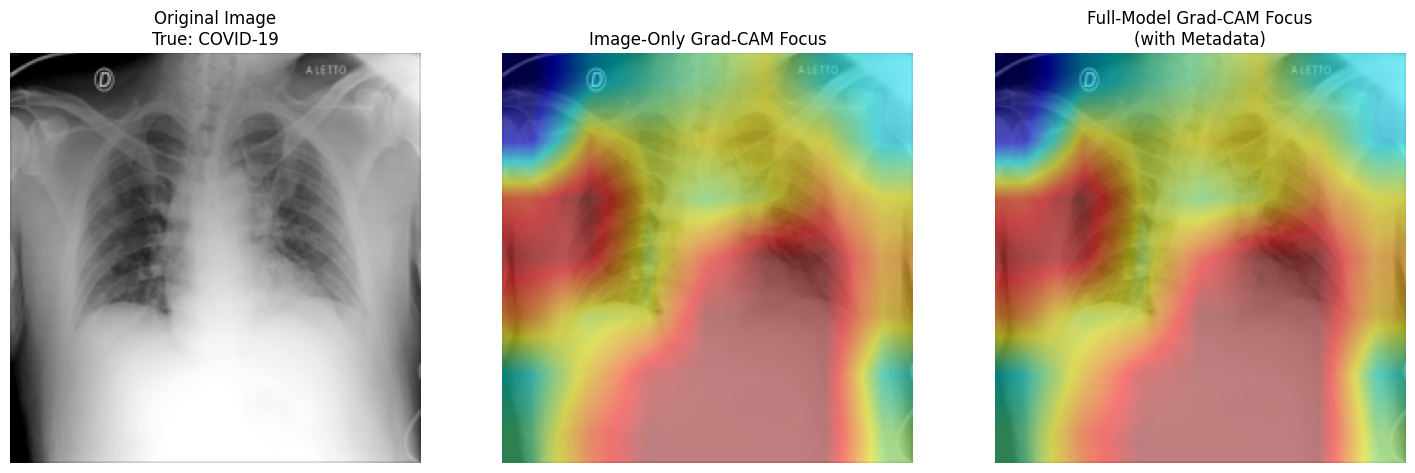

In [22]:
# ==================================================
# ✅ Step 2: Grad-CAM Explainability (Corrected for OpenCV)
# ==================================================
import torch.nn as nn

# A wrapper is needed for Captum
class ModelWrapperForGradCam(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, image, metadata):
        return self.model(image, metadata)

# --- FIX IS HERE: This function now handles the data type conversion ---
def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """Overlays a heatmap onto a numpy image, ensuring data types match."""
    # Convert the base image to uint8 [0, 255] format if it's float [0, 1]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
        
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Both image and heatmap are now uint8, so they can be blended
    overlayed_image = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlayed_image

# --- Setup Grad-CAM ---
model.eval()
wrapped_model = ModelWrapperForGradCam(model)
target_layer = model.image_encoder.backbone.features[-1]
grad_cam = LayerGradCam(wrapped_model, target_layer)

print("✅ Grad-CAM setup complete.")

# --- Run Analysis on a Sample ---
image_tensor, metadata_tensor, label_tensor = next(iter(val_loader))
image_tensor, metadata_tensor, label_tensor = image_tensor[0:1], metadata_tensor[0:1], label_tensor[0:1]
image_tensor, metadata_tensor = image_tensor.to(device), metadata_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor, metadata_tensor)
    prediction = torch.argmax(output, dim=1).item()
    
target_class = prediction
true_label = label_tensor.item()

print(f"Analyzing sample with True Label: '{class_names[true_label]}', Predicted: '{class_names[prediction]}'")

# Full-Model Grad-CAM
attribution_full = grad_cam.attribute(inputs=image_tensor, additional_forward_args=metadata_tensor, target=target_class)
heatmap_full = attribution_full.squeeze().cpu().detach().numpy()
heatmap_full = np.maximum(heatmap_full, 0) / (np.max(heatmap_full) + 1e-8)

# Image-Only Grad-CAM
dummy_metadata = torch.zeros_like(metadata_tensor).to(device)
attribution_img_only = grad_cam.attribute(inputs=image_tensor, additional_forward_args=dummy_metadata, target=target_class)
heatmap_img_only = attribution_img_only.squeeze().cpu().detach().numpy()
heatmap_img_only = np.maximum(heatmap_img_only, 0) / (np.max(heatmap_img_only) + 1e-8)

# --- Visualize the Comparison ---
raw_image_for_viz = denormalize_image(image_tensor.squeeze())
overlay_full = overlay_heatmap(heatmap_full, raw_image_for_viz)
overlay_img_only = overlay_heatmap(heatmap_img_only, raw_image_for_viz)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(raw_image_for_viz)
axs[0].set_title(f"Original Image\nTrue: {class_names[true_label]}")
axs[0].axis('off')

axs[1].imshow(overlay_img_only)
axs[1].set_title("Image-Only Grad-CAM Focus")
axs[1].axis('off')

axs[2].imshow(overlay_full)
axs[2].set_title("Full-Model Grad-CAM Focus\n(with Metadata)")
axs[2].axis('off')

plt.show()

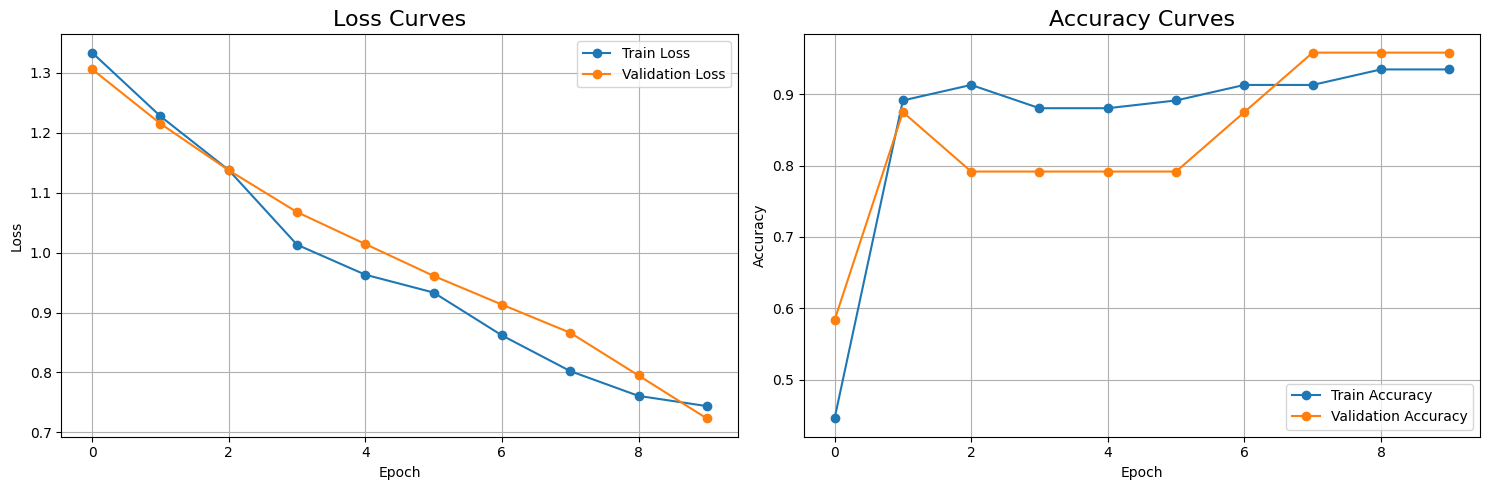

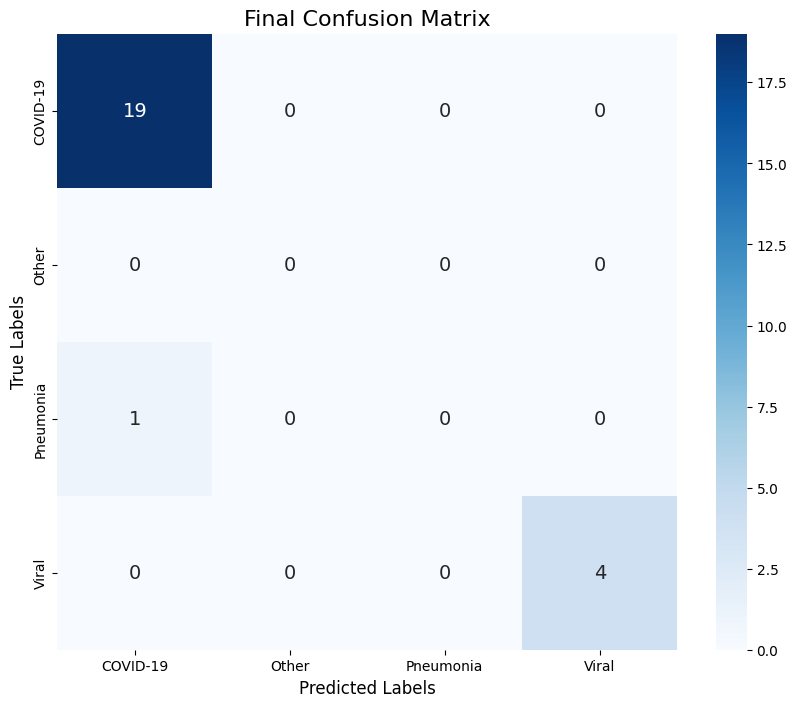

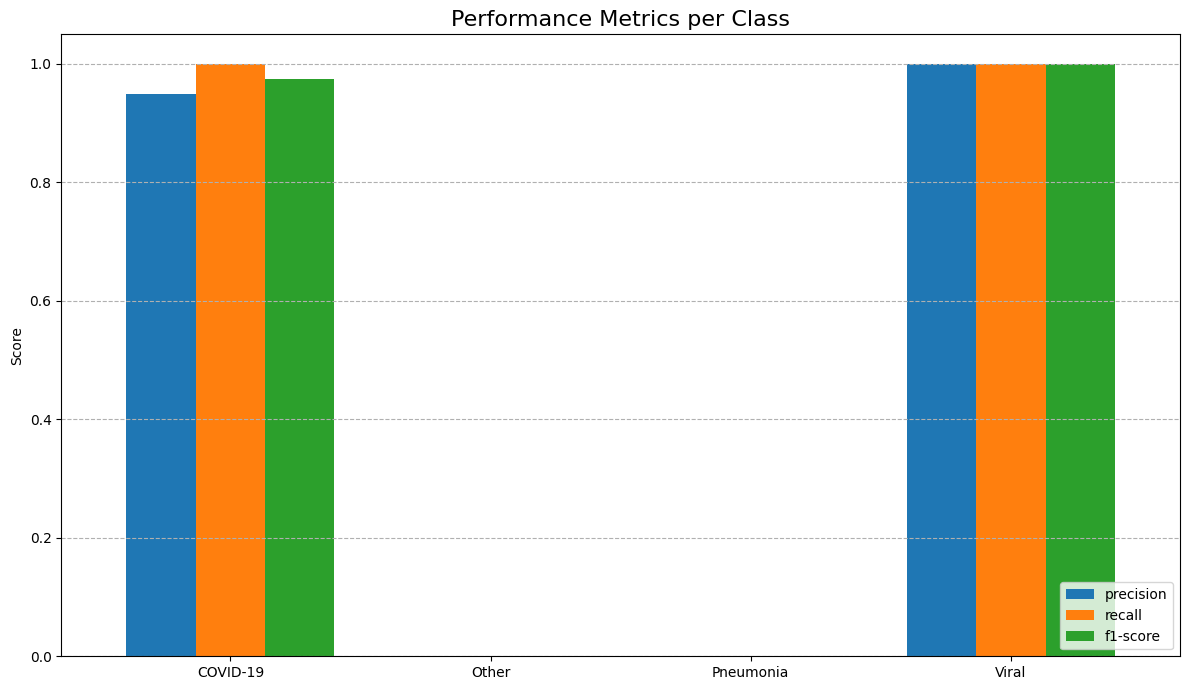

In [23]:
# ==================================================
# ✅ Step 5: Visualize All Performance Metrics
# ==================================================
import matplotlib.pyplot as plt
import seaborn as sns

# The 'val_report' and 'val_cm' variables are from the last epoch of the training loop
final_val_report = val_report
final_val_cm = val_cm

# --- 1. Plot Loss and Accuracy Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Loss Curves', fontsize=16)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_title('Accuracy Curves', fontsize=16)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


# --- 2. Plot Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(final_val_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Final Confusion Matrix', fontsize=16)
plt.show()


# --- 3. Plot Performance Metrics (Precision, Recall, F1-Score) ---
# Extract metrics from the classification report into a pandas DataFrame
report_df = pd.DataFrame(final_val_report).iloc[:-1, :].T
# Ensure we only plot the classes that are in our class_names list
report_df = report_df[report_df.index.isin(class_names)] 

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 7), width=0.8)
plt.title('Performance Metrics per Class', fontsize=16)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()